In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    laugh_labels = [16, 17, 18, 19, 20, 21]
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

In [20]:
g = data_generator(32,'../Data/eval_laugh_speech_subset.tfrecord')
x, y = next(g)

In [22]:
len(x)

32

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM

inp = keras.Input((None, 128))
x = BatchNormalization()(inp)
x = Dropout(.5)(x)
rnn = LSTM(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(rnn)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
batch_size=32
train_gen = data_generator(batch_size,'bal_laugh_subset.tfrecord')
val_gen = data_generator(batch_size,'eval_laugh_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=212,epochs=40,validation_data=val_gen,validation_steps=586//32)

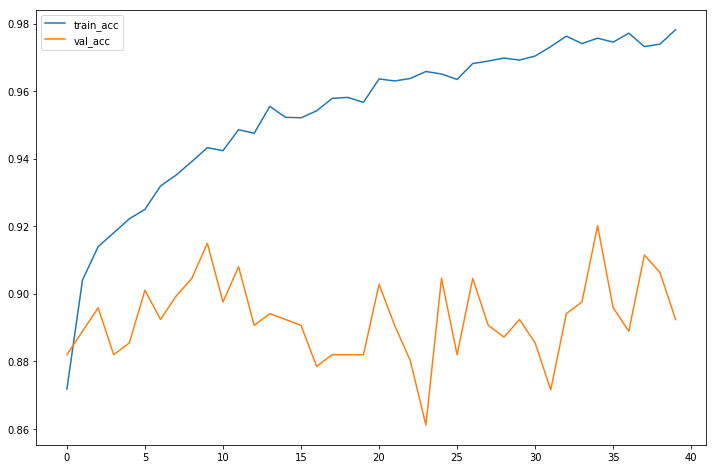

In [152]:
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend()

In [154]:
model.save('Models/LSTM_trained_on_audioset_40epoch.h5')

### Training on Speech/Laughter Subset

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras import regularizers

inp = keras.Input((None, 128))
x = BatchNormalization()(inp)
x = Dropout(.5)(x)
rnn = LSTM(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01))(x)
output = Dense(1, activation='sigmoid')(rnn)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [25]:
batch_size=32
train_gen = data_generator(batch_size,'Data/bal_laugh_speech_subset.tfrecord')
val_gen = data_generator(128,'Data/eval_laugh_speech_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=212,epochs=100,validation_data=val_gen,validation_steps=586//128)

Epoch 1/100
212/212 [==============================] - 9s - loss: 2.5897 - acc: 0.7841 - val_loss: 1.7475 - val_acc: 0.7852
Epoch 2/100
212/212 [==============================] - 7s - loss: 0.9229 - acc: 0.8474 - val_loss: 0.8975 - val_acc: 0.8164
Epoch 3/100
212/212 [==============================] - 7s - loss: 0.5860 - acc: 0.8662 - val_loss: 0.7889 - val_acc: 0.8418
Epoch 4/100
212/212 [==============================] - 8s - loss: 0.5002 - acc: 0.8644 - val_loss: 0.7431 - val_acc: 0.8379
Epoch 5/100
212/212 [==============================] - 8s - loss: 0.4566 - acc: 0.8747 - val_loss: 0.7285 - val_acc: 0.8320
Epoch 6/100
212/212 [==============================] - 7s - loss: 0.4408 - acc: 0.8768 - val_loss: 0.7016 - val_acc: 0.8477
Epoch 7/100
212/212 [==============================] - 7s - loss: 0.4224 - acc: 0.8819 - val_loss: 0.6493 - val_acc: 0.8535
Epoch 8/100
212/212 [==============================] - 7s - loss: 0.4113 - acc: 0.8825 - val_loss: 0.6355 - val_acc: 0.8379
Epoch 9/

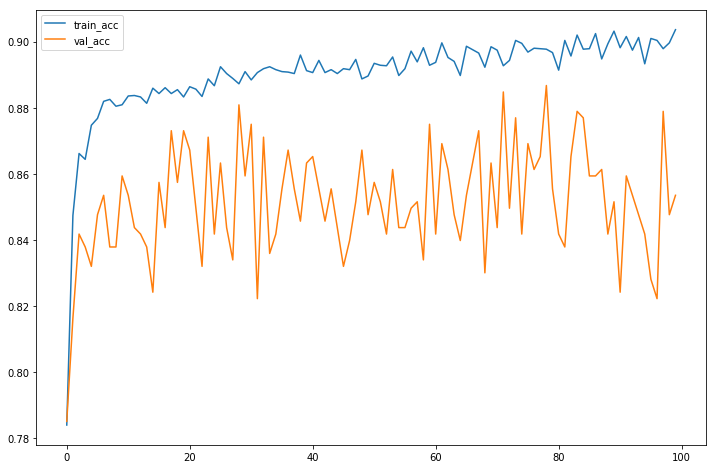

In [26]:
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend()

In [27]:
model.save('Models/LSTM_trained_on_laugh_speech_audioset_100epoch.h5')

## laugh/speech on full audioset

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras import regularizers

inp = keras.Input((None, 128))
x = BatchNormalization()(inp)
x = Dropout(.5)(x)
rnn = LSTM(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01))(x)
output = Dense(1, activation='sigmoid')(rnn)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [26]:
batch_size=32
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord')
val_gen = data_generator(32,'../Data/eval_laugh_speech_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=18768//batch_size,epochs=100,validation_data=val_gen,validation_steps=586//32)

Epoch 1/100
586/586 [==============================] - 27s 47ms/step - loss: 1.3768 - acc: 0.8348 - val_loss: 0.5487 - val_acc: 0.8472
Epoch 2/100
586/586 [==============================] - 24s 41ms/step - loss: 0.4776 - acc: 0.8664 - val_loss: 0.4534 - val_acc: 0.8785
Epoch 3/100
586/586 [==============================] - 23s 39ms/step - loss: 0.4234 - acc: 0.8758 - val_loss: 0.4409 - val_acc: 0.8559
Epoch 4/100
586/586 [==============================] - 23s 38ms/step - loss: 0.4020 - acc: 0.8788 - val_loss: 0.4122 - val_acc: 0.8611
Epoch 5/100
586/586 [==============================] - 22s 38ms/step - loss: 0.3862 - acc: 0.8791 - val_loss: 0.4017 - val_acc: 0.8750
Epoch 6/100
586/586 [==============================] - 23s 39ms/step - loss: 0.3790 - acc: 0.8806 - val_loss: 0.3858 - val_acc: 0.8819
Epoch 7/100
586/586 [==============================] - 24s 41ms/step - loss: 0.3677 - acc: 0.8832 - val_loss: 0.3881 - val_acc: 0.8559
Epoch 8/100
586/586 [==============================] - 

In [30]:
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend()

AttributeError: 'Model' object has no attribute 'history'

In [28]:
model.save('../Models/laugh_speech_full_100.h5')

## 3 layer

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras import regularizers

inp = keras.Input((None, 128))
x = BatchNormalization()(inp)

x = LSTM(128, activation='relu', dropout = 0.5,
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True)(x)
x = LSTM(128, activation='relu', dropout = 0.5,
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True)(x)

x = LSTM(128, activation='relu', dropout = 0.5,
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01))(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
batch_size=32
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord')
val_gen = data_generator(32,'../Data/eval_laugh_speech_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=18768//batch_size,epochs=100,validation_data=val_gen,validation_steps=586//32)

Epoch 1/100
586/586 [==============================] - 38s 64ms/step - loss: 3.5279 - acc: 0.5030 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 2/100
586/586 [==============================] - 33s 57ms/step - loss: 0.6937 - acc: 0.4970 - val_loss: 0.6936 - val_acc: 0.5174
Epoch 3/100
586/586 [==============================] - 29s 50ms/step - loss: 0.6936 - acc: 0.4988 - val_loss: 0.6934 - val_acc: 0.5174
Epoch 4/100
586/586 [==============================] - 25913s 44s/step - loss: 0.6937 - acc: 0.4980 - val_loss: 0.6937 - val_acc: 0.4965
Epoch 5/100
380/586 [==================>...........] - ETA: 48:31 - loss: 0.6937 - acc: 0.4991